# Run the FastScape landscape evolution model

In this notebook, we will see how to import a basic model, inspect the model, create a setup and run the model.

FastScape is implemented using the ``xarray-simlab`` framework. For more info:

- https://xarray-simlab.readthedocs.io/en/latest/inspect_model.html
- https://xarray-simlab.readthedocs.io/en/latest/run_model.html

Let's import some packages first (you can install them using ``conda``).

In [1]:
import numpy as np
import xarray as xr
import xsimlab as xs
import fastscape

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import the basic model

Note: the ``fastscape`` package is not yet available as a ``conda`` package, but it will soon!

In [3]:
from fastscape.models import basic_model

This model simulates the long-term evolution of topographic surface elevation (hereafter noted $h$) on a 2D regular grid. The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift (uniform in space and time) $U$ and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Total erosion $E$ is the combined effect of the erosion of (bedrock) river channels, noted $E_r$, and erosion- transport on hillslopes, noted $E_d$

$$E = E_r + E_d$$

Erosion of river channels is given by the stream power law:

$$E_r = K_r A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

Erosion on hillslopes is given by a linear diffusion law:

$$E_d = K_d \nabla^2 h$$


``xarray-simlab`` is a modular framework, where model inputs are automatically retrieved from model components. ``basic_model`` is a ``xsimlab.Model`` object that contains a bunch of components. Just typing ``basic_model`` shows the ordered list of components as well as all model inputs (parameters), grouped by the component to which they belong:

In [4]:
basic_model

<xsimlab.Model (16 processes, 8 inputs)>
grid
    shape           [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length          [in] ('shape_yx',) total grid length in (y, x)
fs_context
boundary
    status          [in] () or ('border',) node status at borders
uplift
    rate            [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
init_erosion
diffusion
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
flow
drainage
spl
    k_coef          [in] () or ('y', 'x') bedrock channel incision ...
    slope_exp       [in] slope exponent
    area_exp        [in] drainage area exponent
erosion
vmotion
topography
terrain

To have a better picture of all processes (and inputs and/or variables) in the model, we can visualize it as a graph. Processes are in blue and inputs are in yellow. The order in the graph corresponds to the order in which the processes will be exectued during a simulation.

Note: the visualization requires graphviz and python-graphviz packages (both can be installed using conda and the conda-forge channel).

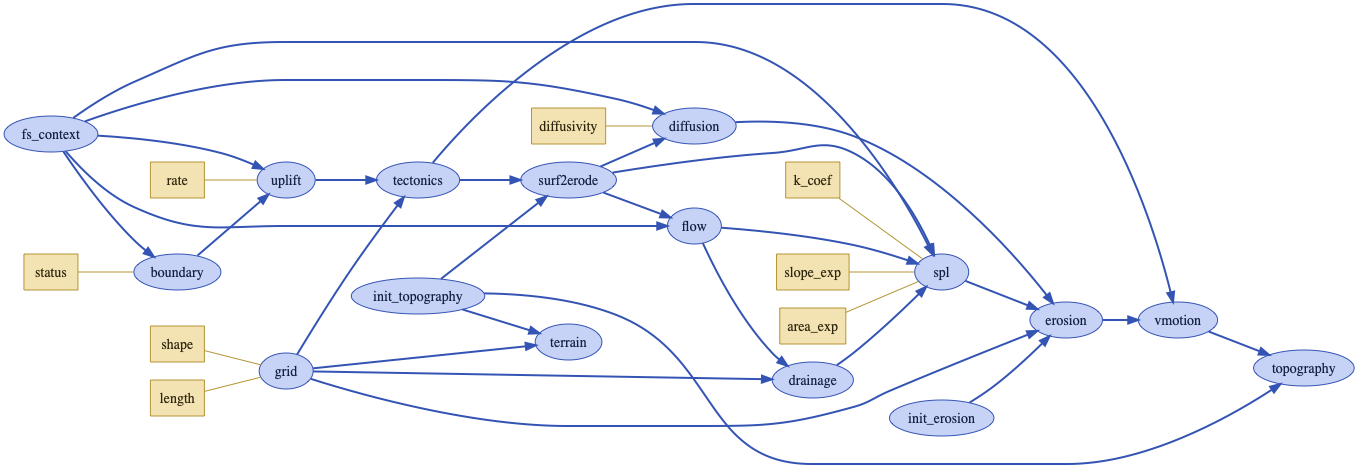

In [5]:
basic_model.visualize(show_inputs=True)

More information can be shown for each process in the model, e.g., for the grid component here below. We can see all the variables defined in that components (thus not only those that are inputs of ``basic_model``).

In [6]:
basic_model.grid

<RasterGrid2D 'grid' (xsimlab process)>
Variables:
    shape         [in] ('shape_yx',) nb. of grid nodes in (y, x)
    size         [out] total nb. of nodes
    area         [out] total grid area
    cell_area    [out] fixed grid cell area
    dx           [out] grid spacing in x (cols)
    dy           [out] grid spacing in y (rows)
    nx           [out] nb. of nodes in x (cols)
    ny           [out] nb. of nodes in y (rows)
    x            [out] ('x',) grid x coordinate
    y            [out] ('y',) grid y coordinate
    length        [in] ('shape_yx',) total grid length in (y, x)
    origin       [out] ('shape_yx',) (y, x) coordinates of grid origin
    spacing      [out] ('shape_yx',) grid node spacing in (y, x)
Simulation stages:
    initialize

## Create a model setup

We create a simulation setup using the `create_setup` function.

In [7]:
nx = 101
ny = 101

in_ds = xs.create_setup(
    model=basic_model,
    clocks={
        'time': np.linspace(0., 1e6, 101),
        'out': np.linspace(0., 1e6, 11)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 201],
        'grid__length': [1e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'spl': {'k_coef': 1e-4, 'area_exp': 0.4, 'slope_exp': 1.},
        'diffusion__diffusivity': 1e-1
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'flow__basin': 'out',
        'spl__chi': None
    }
)

Some explanation about the arguments of `create_setup` and the values given above:

- we specify the model we want to use, here `basic_model`,
- we specify values for clock coordinates (i.e., time coordinates),
- among these coordinates, we specify the master clock, i.e., the coordinate that will be used to
  set the time steps,
- we set values for model inputs (may be grouped by process in the model),
- we set the model variables and the clock coordinate for which we want to take snapshots during a simulation (`None` means that only one snapshot will be taken at the end of the simulation).
  
Here above, we define a 'time' coordinate and another coordinate 'out' with much larger but aligned
time steps (the values are in years). 'time' will be used for the simulation time steps and 'out' will be used to take just a few, evenly-spaced snapshots of
a few variables like topographic elevation, drainage area and catchments. We also save the $\chi$ values at the end of the simulation.

The initial conditions consist here of a nearly flat topographic surface with small random perturbations. Boundaries are periodic on the left and right borders and fixed on the top and bottom borders.

`create_setup` returns a `xarray.Dataset` object that contains everything we need to run the simulation.

More info about xarray: http://xarray.pydata.org/en/stable/

In [8]:
in_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, time: 101)
Coordinates:
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
Dimensions without coordinates: border, shape_yx
Data variables:
    grid__shape             (shape_yx) int64 101 201
    grid__length            (shape_yx) float64 1e+04 2e+04
    boundary__status        (border) <U11 'looped' 'looped' ... 'fixed_value'
    uplift__rate            float64 0.001
    spl__k_coef             float64 0.0001
    spl__area_exp           float64 0.4
    spl__slope_exp          float64 1.0
    diffusion__diffusivity  float64 0.1
Attributes:
    __xsimlab_output_vars__:  spl__chi

If present, the metadata (e.g., description, units, math_symbol...) associated to each input variable in the model are added as attributes in the dataset, e.g.,

In [9]:
in_ds.spl__k_coef

<xarray.DataArray 'spl__k_coef' ()>
array(0.0001)
Attributes:
    description:  bedrock channel incision coefficient

## Run the model

We run the model simply by calling `in_ds.xsimlab.run()`, which returns a new Dataset with both the inputs and the outputs. 

In [10]:
out_ds = in_ds.xsimlab.run(model=basic_model)

out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, time: 101, x: 201, y: 101)
Coordinates:
  * border                  (border) <U6 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * x                       (x) float64 0.0 100.0 200.0 ... 1.99e+04 2e+04
  * y                       (y) float64 0.0 100.0 200.0 ... 9.9e+03 1e+04
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        (border) <U11 'looped' 'looped' ... 'fixed_value'
    diffusion__diffusivity  float64 0.1
    drainage__area          (out, y, x) float64 2e+04 2e+04 ... 2e+04 3e+04
    flow__basin             (out, y, x) int64 591 10798 4860 ... 10469 18474
    grid__length            (shape_yx) float64 1e+04 2e+04
    grid__shape             (shape_yx) int64 101 201
    spl__area_exp           float64 0.4
    spl__chi            

Note for example in `out_ds` the `topography__elevation` variable which has now an additional `out` dimension.

In [11]:
out_ds.topography__elevation

<xarray.DataArray 'topography__elevation' (out: 11, y: 101, x: 201)>
array([[[6.17651316e-01, 4.98845095e-01, 4.25647555e-01, ...,
         7.02208812e-02, 6.32949632e-01, 5.26724440e-01],
        [4.55819362e-01, 9.03233546e-01, 5.54028844e-01, ...,
         2.66105268e-02, 3.06947166e-02, 2.17189776e-01],
        [2.13051944e-01, 6.70605374e-01, 8.65479235e-01, ...,
         8.15036607e-01, 9.99764962e-01, 6.47695404e-02],
        ...,
        [4.11864463e-01, 2.94124296e-01, 6.30494660e-01, ...,
         1.16050480e-02, 3.03180665e-01, 9.79396906e-01],
        [9.42015603e-01, 5.48975858e-01, 8.84611673e-01, ...,
         2.64017813e-02, 7.33995904e-01, 5.26074999e-01],
        [6.23358405e-01, 1.71569061e-02, 5.93622803e-01, ...,
         3.83159375e-01, 4.23257174e-01, 5.16990340e-01]],

       [[6.17651316e-01, 4.98845095e-01, 4.25647555e-01, ...,
         7.02208812e-02, 6.32949632e-01, 5.26724440e-01],
        [2.44326343e+01, 1.61312598e+01, 1.64054146e+01, ...,
         1.363

## Analyse, plot and save the results (some examples)

Having all the input and output data bundled into a ``xarray.Dataset`` is very convenient to further do some post-processing, visualization or writing the results to disk (e.g., as a netCDF file).

``xarray`` is a powerful library that is well connected to other libraries of the scientific Python ecosystem.

Plot the elevation values at the end of the simulation (note: the xarray plotting functions are built on top of the [matplotlib](https://matplotlib.org/) library):

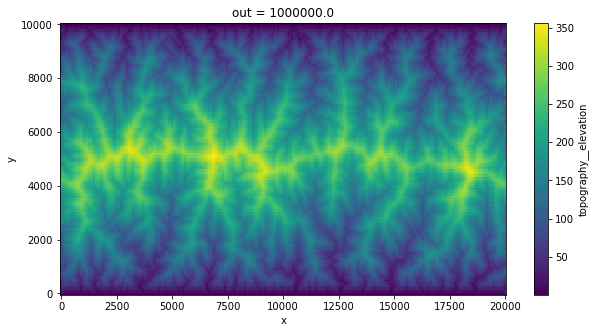

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

out_ds.isel(out=-1).topography__elevation.plot(size=5, aspect=2);

Or plot it at a given time (one label of the ``out`` coordinate):

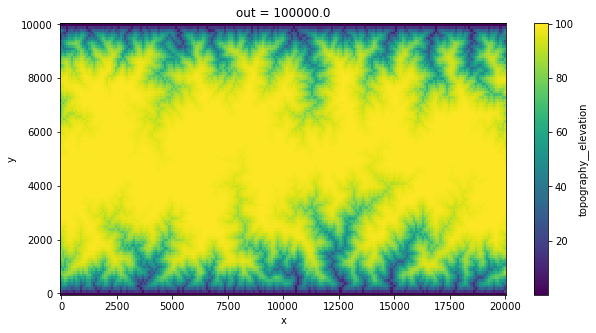

In [13]:
out_ds.sel(out=1e5).topography__elevation.plot(size=5, aspect=2);

It is also easy to extract profiles and plot it:

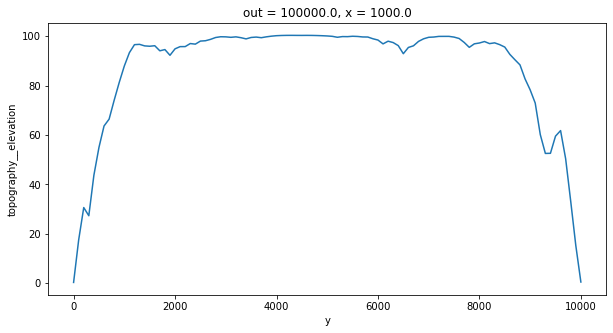

In [14]:
out_ds.sel(out=1e5, x=1000).topography__elevation.plot(size=5, aspect=2);

Or extract and plot swath profiles:

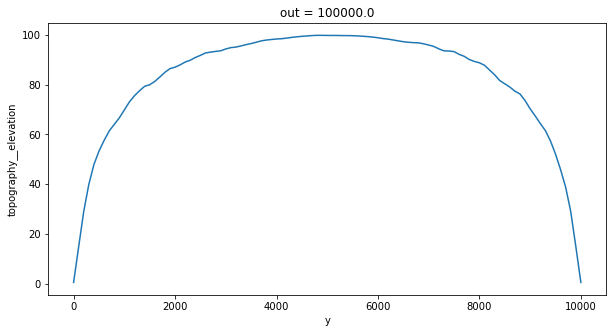

In [15]:
out_ds.sel(out=1e5).mean(dim='x').topography__elevation.plot(size=5, aspect=2);

With ``xarray``, you can extract the same swath profile for all output variables (and all saved time steps) at once:

In [16]:
out_ds.mean(dim='x')

<xarray.Dataset>
Dimensions:                 (border: 4, out: 11, shape_yx: 2, time: 101, y: 101)
Coordinates:
  * border                  (border) <U6 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 8e+05 9e+05 1e+06
  * time                    (time) float64 0.0 1e+04 2e+04 ... 9.9e+05 1e+06
  * y                       (y) float64 0.0 100.0 200.0 ... 9.9e+03 1e+04
Dimensions without coordinates: shape_yx
Data variables:
    diffusion__diffusivity  float64 0.1
    drainage__area          (out, y) float64 6.279e+05 6.179e+05 ... 5.105e+05
    flow__basin             (out, y) float64 1.075e+04 1.075e+04 ... 9.854e+03
    grid__length            (shape_yx) float64 1e+04 2e+04
    grid__shape             (shape_yx) float64 101.0 201.0
    spl__area_exp           float64 0.4
    spl__chi                (y) float64 0.0 9.289 16.62 ... 17.21 8.984 0.0
    spl__k_coef             float64 0.0001
    spl__slope_exp          float64 1.0
    topography_

We can also use ``hvplot`` (built on top of ``holoviews`` and ``bokeh``) to create interactive figures.

More info: https://hvplot.pyviz.org/user_guide/Gridded_Data.html

In [17]:
import hvplot.xarray

out_ds.topography__elevation.hvplot.image(x='x', y='y',
                                          cmap=plt.cm.viridis,
                                          groupby='out')

:DynamicMap   [out]
   :Image   [x,y]   (topography__elevation)

In [18]:
out_ds.flow__basin.hvplot.image(x='x', y='y',
                                cmap=plt.cm.tab20b,
                                width=800)

:DynamicMap   [out]
   :Image   [x,y]   (flow__basin)

In [19]:
out_ds.mean(dim='x').topography__elevation.hvplot(groupby='out', ylim=(0, 300))

:DynamicMap   [out]
   :Curve   [y]   (topography__elevation)

As a more advanced example, let's extract mean elevation for the largest drainage basins at the last time step.  

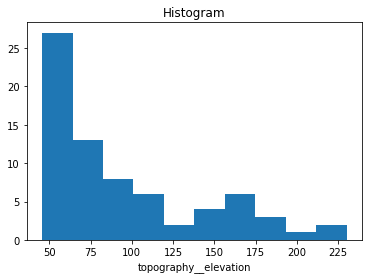

In [20]:
# extract last time step dataset
last_step_ds = out_ds.isel(out=-1)

# count the number of grid nodes in each basin
nnodes_per_basin = last_step_ds.groupby('flow__basin').count()

# get ids of large basins (i.e., more than 10 nodes)
basin_ids = (xr.where(nnodes_per_basin.topography__elevation > 10, 1, np.nan)
               .dropna('flow__basin')
               .flow__basin)

# extract mean elevation per basin
mean_elev = last_step_ds.groupby('flow__basin').mean().topography__elevation

# select only large basins
mean_elev_basins = mean_elev.sel(flow__basin=basin_ids)

# show histogram
mean_elev_basins.plot.hist();

Export the simulations data as netCDF files:

In [21]:
# TODO: Fix border fillvalue issue
out_ds.border.attrs.pop("_FillValue")

in_ds.to_netcdf('basic_input.nc')

out_ds.to_netcdf('basic_output.nc')